# SXT RMF Generator

**Author:** Saikruba Krishnan  
**Affiliation:** The Inter-University Center for Astronomy and Astrophysics (IUCAA )   
**Email:** saikruba.krishnan@iucaa.in  
**Date Created:** 2025-05-14  
**Last Updated:** 2025-11-27  
**Notebook Version:** v3.  


---
This program is developed to model, process, and calibrate the Response Matrix File (RMF) for the AstroSat Soft X-ray Telescope (SXT). 

The program uses analytical model capable of reproducing the RMF shape using key detector and physical parameters. It generates synthetic RMFs across a defined parameter space to study response variations and assess model behavior to determine the optimal set of parameters that can be further used for updating the RMFs.

---

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import gridspec
import scipy.integrate
import sys
import os
from astropy.io import fits
from pathlib import Path
from matplotlib.cm import get_cmap

---
### 📥 Inputs
- `sxt_pc_mat_g0to4.rmf` – Original RMF file.  
- `attcoeff.dat` – Attenuation coefficient values, $\mu(\rm E)$.
- Input model parameter values for new RMF.


### 📤 Outputs
-  Multiple New modified RMF files with updated values
-  

---

##  I. RMF Model Description and Parameterization

**Model Parameters:**  
- `Ein` — Input X-ray Photon Energy
- μ    — attenuation coefficient (1/μm)  
- σ    — Energy Resolution  
- τ    — Damping coefficient (μm)
- l    — Transition depth of energy loss functions (μm)  
- f₀   — fractional Energy loss at Surface 
- β    — Shape parameter for shoulder due to charge loss
- norm — normalization factor


In [3]:
#Input Directory
InputDir = './input/'

In [82]:
manual_points = [
    {'energy': 0.848, 'f0': 0.224, 'beta': 0.3135, 'beta_err': 0.01310857, 'sigma': 0.033 , 'tau': 0.0821, 'norm':27.9,},
    {'energy': 1.002, 'f0': 0.051,  'beta': 0.1736, 'beta_err': 0.22404055, 'sigma': 0.033, 'tau': 0.1168, 'norm':41.2},
    {'energy': 1.248, 'f0': 0.021,  'beta': 0.1386, 'beta_err': 0.31532757,  'sigma': 0.037, 'tau': 0.084, 'norm':56.8},
    {'energy': 1.452, 'f0': 0.224,  'beta': 0.1553, 'beta_err': 0.07682427, 'sigma': 0.041, 'tau': 0.1331, 'norm':94.9},
    {'energy': 1.602, 'f0': 0.203579,  'beta': 0.234396, 'beta_err': 0.01760691,  'sigma': 0.039649, 'tau': 0.564159, 'norm':136.189},
    {'energy': 1.72, 'f0': 0.09557,  'beta': 0.174496, 'beta_err': 0.00812021,  'sigma': 0.039649, 'tau': 0.6844591, 'norm':164.889},
    {'energy': 1.78, 'f0': 0.139,  'beta': 0.132, 'beta_err': 0.00659204,  'sigma': 0.045, 'tau': 0.4507, 'norm':131.5},
    {'energy': 2.68, 'f0': 0.543,  'beta': 0.9744, 'beta_err': 0.03148889,  'sigma': 0.046, 'tau': 0.0389, 'norm':46.1},
    {'energy': 4.2025, 'f0': 0.707188,  'beta': 0.30530666, 'beta_err': 0.0,  'sigma': 0.05546032, 'tau': 0.11443, 'norm':179.4965},
    {'energy': 5.9425, 'f0': 0.685,  'beta': 0.13637179, 'beta_err': 0.0,  'sigma': 0.06187148, 'tau': 0.952488, 'norm':619.7565},
    {'energy': 6.52, 'f0': 0.725,  'beta': 0.1553, 'beta_err': 0.0,  'sigma': 0.067, 'tau': 1.291, 'norm':1277.2}
]


# Extract parameters
energies = [p['energy'] for p in manual_points]
f0 = [p['f0'] for p in manual_points]
sigma = [p['sigma'] for p in manual_points]
tau = [p['tau'] for p in manual_points]
beta = [p['beta'] for p in manual_points]
beta_err = [p['beta_err'] for p in manual_points]
norm = [p['norm'] for p in manual_points]

## II. Constraints on the Model Parameters

#### Energy Resolution - $\sigma$

[0.4125   0.4175   0.4225   ... 8.6475   8.6525   8.657499]


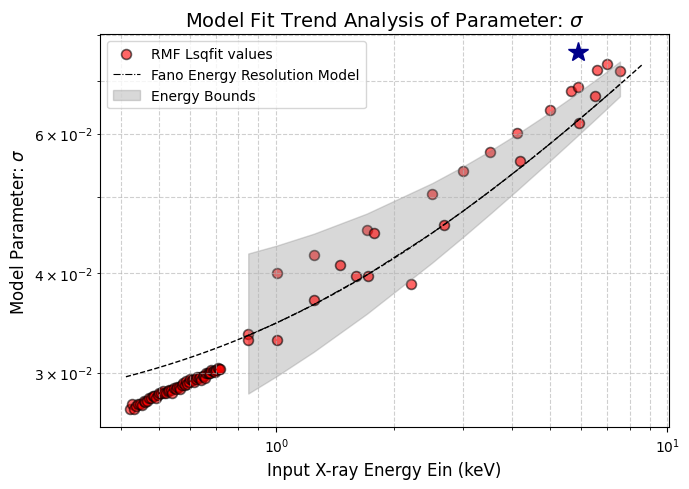

In [124]:
SigmaModel = np.loadtxt(os.path.join(InputDir, 'sigma_Model.dat'))
SigmaFit   = np.loadtxt(os.path.join(InputDir, 'sigma_Lsqfit.dat'))

sigmaEn_model, sigma_model = SigmaModel[:, 0], SigmaModel[:, 1]
sigmaEn_fit,   sigma_fit   = SigmaFit[:, 0],   SigmaFit[:, 1]

SigmaModel2 = np.loadtxt(os.path.join(InputDir, 'sigma_Model_bounds.dat'))
# extract arrays
sigmaEn_model2 = SigmaModel2[:, 0]
sigma_model2 = SigmaModel2[:, 1]

sigma_lo = SigmaModel2[:, 2]   # lower error
sigma_hi = SigmaModel2[:, 3]   # upper error

# asymmetric error array for matplotlib
sigma_err = np.array([sigma_lo, sigma_hi])



rootdir2 = '/home/saikruba/Desktop/prog/fit/param_space/rmf_generator/XMM_rmfGen/'
data2 = np.loadtxt(rootdir2 + 'avg_Ein.dat')
#Energy of the input X-ray photon energy in keV
E =data2[82:1732]
print(E)
#Energy to create electron-hole pair in Si: 3.65 eV 
w= (3.65)*(10**-3) 

#Read-out noise in electrons 
sig_rdot = 7


#Fano factor

F= 0.15

#no. of electron-hole pairs generated
N= [] 

sig_fano = []


for i in range(len(E)):
    N.append(E[i]/w)
    val = E[i]/w
    sig_fano.append((w)*np.sqrt((val*F)+(sig_rdot)**2))



plt.figure(figsize=(7,5))
plt.scatter(sigmaEn_fit, sigma_fit , color='red', alpha=0.6, s=50, edgecolors='black', linewidths=1.2, label=r'RMF Lsqfit values')

#plt.plot(sigmaEn_model, sigma_model, color='k', linestyle='-.', linewidth=0.8, label=r'Fano Energy Resolution Model')
#plt.plot(sigmaEn_model, sigma_model2, color='red', linestyle='--', linewidth=1.5, label=r'Fano Energy Resolution Model7')
#plt.plot(sigmaEn_model, sigma_lo, color='k', linestyle='--', linewidth=1.0)
plt.plot(E, sig_fano, color='k', linestyle='--', linewidth=1.0)

# central curve
plt.plot(
    sigmaEn_model2, sigma_model2,
    color='k', linestyle='-.', linewidth=0.8,
    label=r'Fano Energy Resolution Model'
)

# fill between lower and upper bounds
plt.fill_between(
    sigmaEn_model2,
    sigma_lo,        # already absolute lower bound
    sigma_hi,        # already absolute upper bound
    color='grey',
    alpha=0.3,
    label='Energy Bounds'
)

#plt.plot(E, sig_fano, lw=1.5,ls='--', color='k', label=r'Fano stat, $\sigma_{rdout}= 7$')
plt.xscale('log'); plt.yscale('log')
plt.title(r'Model Fit Trend Analysis of Parameter: $\sigma$', fontsize=14)
plt.xlabel('Input X-ray Energy Ein (keV)', fontsize=12)
plt.ylabel(r'Model Parameter: $\sigma$', fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.plot(5.9, 0.076, marker='*', markersize=15, color='darkblue')
plt.scatter(energies, sigma, color='red', alpha=0.6, s=50,
            edgecolors='black', linewidths=1.2, label='Manual fit')
plt.savefig('Model_Parameters_Analysis_Sigma.pdf')

plt.show()

#### Damping Coefficient - $\tau$

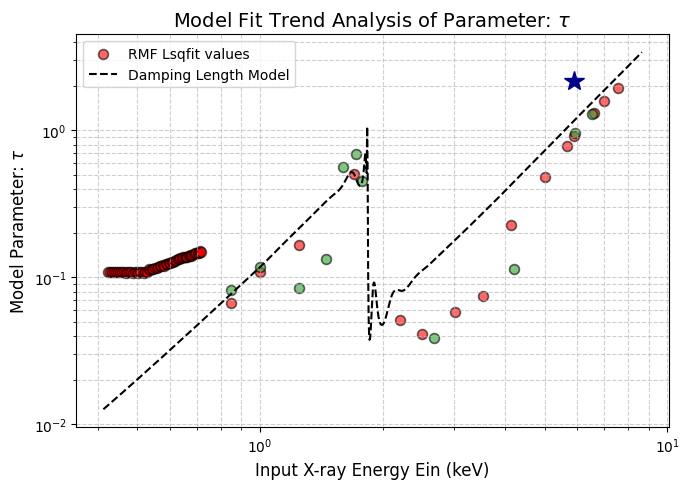

In [116]:
TauModel = np.loadtxt(os.path.join(InputDir, 'tau_Model.dat'))
TauFit   = np.loadtxt(os.path.join(InputDir, 'tau_Lsqfit.dat'))

tauEn_model, tau_model = TauModel[:, 0], TauModel[:, 1]
tauEn_fit,  tau_fit   = TauFit[:, 0],   TauFit[:, 1]


plt.figure(figsize=(7,5))
plt.scatter(tauEn_fit, tau_fit , color='red', alpha=0.6, s=50, edgecolors='black', linewidths=1.2, label=r'RMF Lsqfit values')
plt.plot(tauEn_model, tau_model, color='k', linestyle='--', linewidth=1.5, label=r'Damping Length Model')
plt.xscale('log'); plt.yscale('log')
plt.title(r'Model Fit Trend Analysis of Parameter: $\tau$', fontsize=14)
plt.xlabel('Input X-ray Energy Ein (keV)', fontsize=12)
plt.ylabel(r'Model Parameter: $\tau$', fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
#plt.savefig('Model_Parameters_Analysis_Tau.pdf')
plt.plot(5.9, 2.17, marker='*', markersize=15, color='darkblue')

plt.scatter(energies, tau, color='#2ca02c', alpha=0.6, s=50,
            edgecolors='black', linewidths=1.2, label='Manual fit')
plt.savefig('Model_Parameters_Analysis_Tau.pdf')
plt.show()

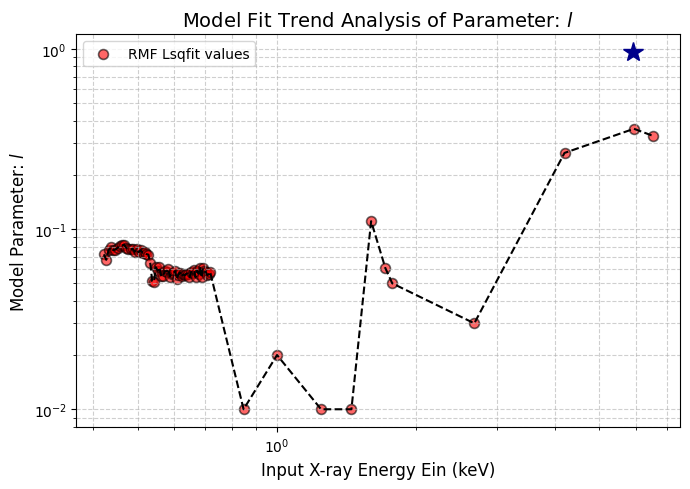

In [125]:
#TauModel = np.loadtxt(os.path.join(InputDir, 'tau_Model.dat'))
LFit   = np.loadtxt(os.path.join(InputDir, 'l_Lsqfit.dat'))

#tauEn_model, tau_model = TauModel[:, 0], TauModel[:, 1]
lEn_fit,  l_fit   = LFit[:, 0],   LFit[:, 1]


plt.figure(figsize=(7,5))
plt.scatter(lEn_fit, l_fit , color='red', alpha=0.6, s=50, edgecolors='black', linewidths=1.2, label=r'RMF Lsqfit values')
plt.plot(lEn_fit, l_fit , color='k', linestyle='--', linewidth=1.5)
#plt.plot(tauEn_model, tau_model, color='k', linestyle='--', linewidth=1.5, label=r'Damping Length Model')
plt.xscale('log'); plt.yscale('log')
plt.title(r'Model Fit Trend Analysis of Parameter: $l$', fontsize=14)
plt.xlabel('Input X-ray Energy Ein (keV)', fontsize=12)
plt.ylabel(r'Model Parameter: $l$', fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.plot(5.9, 0.96, marker='*', markersize=15, color='darkblue')
#plt.scatter(energies, tau, color='#2ca02c', alpha=0.6, s=50, edgecolors='black', linewidths=1.2, label='Manual fit')
plt.savefig('Model_Parameters_Analysis_l.pdf')
plt.show()

#### Fractional Energy Loss at Surface - $f0$

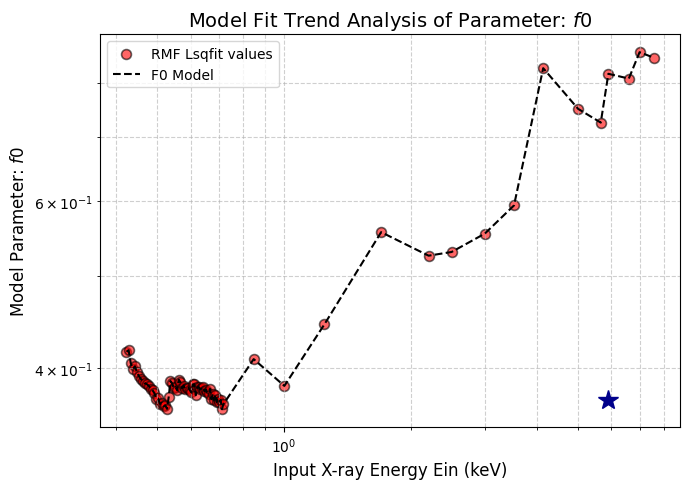

In [121]:
F0Model = np.loadtxt(os.path.join(InputDir, 'f0_Model.dat'))
F0Fit   = np.loadtxt(os.path.join(InputDir, 'f0_Lsqfit.dat'))

f0En_model, f0_model = F0Model[:, 0], F0Model[:, 1]
f0En_fit,  f0_fit   = F0Fit[:, 0],   F0Fit[:, 1]


plt.figure(figsize=(7,5))
plt.scatter(f0En_fit, f0_fit , color='red', alpha=0.6, s=50, edgecolors='black', linewidths=1.2, label=r'RMF Lsqfit values')
plt.plot(f0En_fit, f0_fit, color='k', linestyle='--', linewidth=1.5, label=r'F0 Model')
#plt.plot(f0En_fit, f0_fit, color='grey', linestyle='--', linewidth=1.5, label=r'F0 Model')
#plt.plot(f0En_model, f0_model, color='k', linestyle='--', linewidth=1.5, label=r'F0 Model')
plt.xscale('log'); plt.yscale('log')
plt.title(r'Model Fit Trend Analysis of Parameter: $f0$', fontsize=14)
plt.xlabel('Input X-ray Energy Ein (keV)', fontsize=12)
plt.ylabel(r'Model Parameter: $f0$', fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
#plt.savefig('Model_Parameters_Analysis_F0.pdf')
#plt.plot(5.9, 0.75, marker='*', markersize=15, color='darkblue')
plt.plot(5.9, 0.37, marker='*', markersize=15, color='darkblue')
#plt.scatter(energies, f0, color='#2ca02c', alpha=0.6, s=50,
#            edgecolors='black', linewidths=1.2, label='Manual fit')
plt.savefig('Model_Parameters_Analysis_f0.pdf')
plt.show()

#### Shaping Parameter - $\beta$

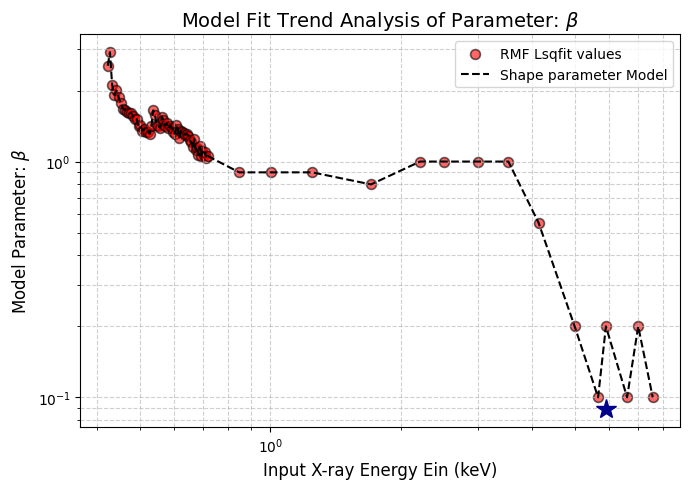

In [110]:
BetaModel = np.loadtxt(os.path.join(InputDir, 'beta_Model.dat'))
BetaFit   = np.loadtxt(os.path.join(InputDir, 'beta_Lsqfit.dat'))

betaEn_model, beta_model = BetaModel[:, 0], BetaModel[:, 1]
betaEn_fit,  beta_fit   = BetaFit[:, 0],   BetaFit[:, 1]


plt.figure(figsize=(7,5))
plt.scatter(betaEn_fit, beta_fit , color='red', alpha=0.6, s=50, edgecolors='black', linewidths=1.2, label=r'RMF Lsqfit values')
plt.plot(betaEn_fit, beta_fit, color='k', linestyle='--', linewidth=1.5, label=r'Shape parameter Model')
plt.xscale('log'); plt.yscale('log')
plt.title(r'Model Fit Trend Analysis of Parameter: $\beta$', fontsize=14)
plt.xlabel('Input X-ray Energy Ein (keV)', fontsize=12)
plt.ylabel(r'Model Parameter: $\beta$', fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
#plt.savefig('Model_Parameters_Analysis_Beta.pdf')
#plt.plot(5.9, 0.3, marker='*', markersize=15, color='darkblue')
plt.plot(5.9, 0.089, marker='*', markersize=15, color='darkblue')
#plt.scatter(energies, beta, color='#2ca02c', alpha=0.6, s=50,
#            edgecolors='black', linewidths=1.2, label='Manual fit')
plt.savefig('Model_Parameters_Analysis_beta.pdf')
plt.show()

#### Normalization factor - $norm$


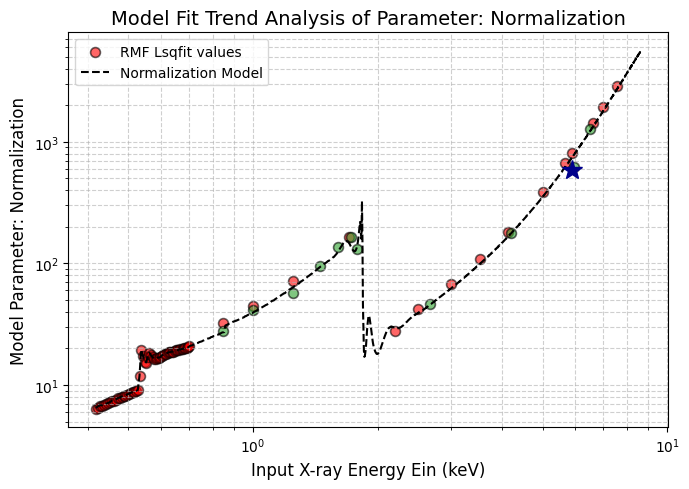

In [96]:
NormModel = np.loadtxt(os.path.join(InputDir, 'norm_Model.dat'))
NormFit   = np.loadtxt(os.path.join(InputDir, 'norm_Lsqfit.dat'))

normEn_model, norm_model = NormModel[:, 0], NormModel[:, 1]
normEn_fit,   norm_fit   = NormFit[:, 0],   NormFit[:, 1]

plt.figure(figsize=(7,5))
plt.scatter(normEn_fit, norm_fit , color='red', alpha=0.6, s=50, edgecolors='black', linewidths=1.2, label='RMF Lsqfit values')

plt.plot(normEn_model, norm_model, color='k', linestyle='--', linewidth=1.5, label=r'Normalization Model')
plt.xscale('log'); plt.yscale('log')
plt.title(r'Model Fit Trend Analysis of Parameter: Normalization', fontsize=14)
plt.xlabel('Input X-ray Energy Ein (keV)', fontsize=12)
plt.ylabel(r'Model Parameter: Normalization', fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
#plt.savefig('Model_Parameters_Analysis_Norm.pdf')
plt.plot(5.9, 586.914, marker='*', markersize=15, color='darkblue')
plt.scatter(energies, norm, color='#2ca02c', alpha=0.6, s=50,
            edgecolors='black', linewidths=1.2, label='Manual fit')
plt.show()

## **III. RMF Model**

The RMF is constructed by dividing the incident energy $(E_{\rm in})$ range into three regimes.  
Each Energy regime is modeled by : `mormf_set1`, `mormf_set2`, and `mormf_set3`.

#### **`mormf_set1` — Set 1 (0.4175–1.8375 keV)**
This model describes the low-energy response where:
- the main peak deviates from an ideal Gaussian shape,
- shoulder-like features emerge.
- **primary photopeak with shoulder**

#### **`mormf_set2` — Set 2 (1.8425–5.7875 keV)**
This model represents the intermediate-energy region characterized by:
- a well-defined **primary photopeak with shoulder**,
- an **escape peak** appearing at $(E_{\rm in} - E_{\rm Si})$ keV,


#### **`mormf_set3` — Set 3 (5.7925–10.2475 keV)**
This model covers the high-energy regime exhibiting:
- the main **photopeak with shoulder**,
- an **escape peak** at $(E_{\rm in} - E_{\rm Si})$ keV,
- a **fluorescence peak** at $(E_{\rm Si})$ keV,
- additional small off-peak features associated with readout noise and scattering.



In [10]:
# We Import the Model Functions
sys.path.append('./input/RMF_model/')
from model_set1 import mormf_set1 
from model_set2 import mormf_set2 
from model_set3 import mormf_set3 

## IV. RMF Generator

# RMF Generator for a Range of $\beta$ 

In [11]:

# -----------------------------------
# Plotting function 
# -----------------------------------
def plot_rmf_set1(E_channel, rmf_dist, mormf_dist_list, Ein, pdf, labels=None):
    """
    Plot the original RMF and multiple model RMFs (v1,v2,v3) for the same Ein.
    mormf_dist_list: list of mormf arrays
    labels: list of strings for legend
    """
    plt.figure(figsize=(8,5))

    # Original RMF
    plt.plot(E_channel, rmf_dist, 'o-', color='k', ms=1.5, lw=1,
             alpha=0.8, label=f"SXT RMF @ {Ein:.4f} keV")

    n = len(mormf_dist_list)
    cmap = get_cmap("viridis")

    for i, mormf in enumerate(mormf_dist_list):
        color = cmap(i / max(1, n-1))
        label = labels[i] if labels is not None else f"model v{i+1}"
        plt.plot(E_channel, mormf, color=color, lw=2, label=label)

    plt.xscale("log")
    plt.yscale("log")
    plt.xlim(0.05, 2.2)
    plt.ylim(1e-6, 1e-1)
    plt.xlabel("Energy Channel (keV)")
    plt.ylabel("N(x) distribution")
    plt.title(f"SXT RMF model for Ein = {Ein:.4f} keV")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    pdf.savefig()
    plt.close()

def plot_rmf_set2(E_channel, rmf_dist, mormf_dist_list, Ein, pdf, labels=None):
    """
    Plot the original RMF and multiple model RMFs (v1,v2,v3) for the same Ein.
    mormf_dist_list: list of mormf arrays
    labels: list of strings for legend
    """
    plt.figure(figsize=(8,5))

    # Original RMF
    plt.plot(E_channel, rmf_dist, 'o-', color='k', ms=1.5, lw=1,
             alpha=0.8, label=f"SXT RMF @ {Ein:.4f} keV")

    n = len(mormf_dist_list)
    cmap = get_cmap("viridis")

    for i, mormf in enumerate(mormf_dist_list):
        color = cmap(i / max(1, n-1))
        label = labels[i] if labels is not None else f"model v{i+1}"
        plt.plot(E_channel, mormf, color=color, lw=2, label=label)

    plt.xscale("log")
    plt.yscale("log")
    plt.xlim(0.05, 11)
    plt.ylim(1e-11, 1e6)
    plt.xlabel("Energy Channel (keV)")
    plt.ylabel("N(x) distribution")
    plt.title(f"SXT RMF model for Ein = {Ein:.4f} keV")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    pdf.savefig()
    plt.close()

In [12]:
# ==== PREPARE OUTPUT FOLDERS ====
versions = ["v1", "v2", "v3"]
base_output_dir = Path("./output")

output_dirs = {}
for v in versions:
    d = base_output_dir / v
    d.mkdir(parents=True, exist_ok=True)
    output_dirs[v] = d

# ==== LOAD ORIGINAL RMF ====
InputRMF = 'sxt_pc_mat_g0to4.rmf'
file = fits.open(InputRMF)
matrix_data = file['MATRIX'].data

# Make 3 SEPARATE COPIES of MATRIX data
matrix_data_versions = {
    "v1": matrix_data.copy(),
    "v2": matrix_data.copy(),
    "v3": matrix_data.copy()
}

# ==== PLOT OUTPUT ====
PlotDir = './Updated_RMF/Modified_RMF_plots/'
os.makedirs(PlotDir, exist_ok=True)
pdf_filename = os.path.join(PlotDir, 'Modified_RMF_test_FullE.pdf')

#========Params Directory ===========
RmfDir ='./input/RMF_G0to4/'
paramsDir = './input/params/'

# ======================================================================
#                           MAIN LOOP
# ======================================================================
with PdfPages(pdf_filename) as pdf:

# ======================================================================
#                         RMF SET1 Model
# ======================================================================

    for i in range(285):
        idx = 83 + i

        # --- Load input RMF ---
        RMFg0to4 = np.loadtxt(os.path.join(RmfDir, f'rmf_{idx}.dat'))
        E_channel = RMFg0to4[:, 0] * 1e-2
        RMFDist   = RMFg0to4[:, 1]

        # --- Load Ein, μ ---
        AttCoeff = np.loadtxt(os.path.join(paramsDir, 'attcoeff.dat'))
        Ein, mu = AttCoeff[:, 0][idx], AttCoeff[:, 1][idx]

        # --- Load parameters ---
        l = 1.74
        tau  = np.loadtxt(os.path.join(paramsDir, 'tau_val.dat'))[:, 1][i]
        sig  = np.loadtxt(os.path.join(paramsDir, 'sigma_val.dat'))[:, 1][i]
        norm = np.loadtxt(os.path.join(paramsDir, 'norm_val.dat'))[:, 1][i]
        Bt0 = np.loadtxt(os.path.join(paramsDir, 'beta_val.dat'))[:, 1][i]
        f0 = np.loadtxt(os.path.join(paramsDir, 'f0_val.dat'))[:, 1][i]
       

        # Deviations for v1, v2, v3
        deviations = {
            "v1": 0.0,
            "v2": -0.2,
            "v3": +0.2
        }

        # ================================================================
        #             Generate 3 RMFs (v1, v2, v3) for this energy
        # ================================================================
        mormf_list = []
        labels = []

        for v in versions:

            Bt = Bt0 + deviations[v]

            mormf = mormf_set1(E_channel, l, Bt, sig, tau, norm, f0, mu, Ein)

            # Save RMF .dat under its own folder ./output/v1/, v2/, v3/
            np.savetxt(
                output_dirs[v] / f"mormf_{idx}.dat",
                np.column_stack([E_channel, mormf, RMFDist - mormf]),
                fmt="%.20g"
            )

            # Store inside proper FITS matrix copy
            matrix_data_versions[v][idx][5] = mormf

            # Collect for plotting
            mormf_list.append(mormf)
            labels.append(v)

        # Plot all 3 versions in one figure
        plot_rmf_set1(E_channel, RMFDist, mormf_list, Ein, pdf, labels)

# ======================================================================
#                         RMF SET2 Model
# ======================================================================

    for j in range(790):
       
        idx = 368+j

        # --- Load input RMF ---
        RMFg0to4 = np.loadtxt(os.path.join(RmfDir, f'rmf_{idx}.dat'))
        E_channel = RMFg0to4[:, 0] * 1e-2
        RMFDist   = RMFg0to4[:, 1]
        
        # --- Load Ein, μ ---
        AttCoeff = np.loadtxt(os.path.join(paramsDir, 'attcoeff.dat'))
        Ein, mu = AttCoeff[:, 0][idx], AttCoeff[:, 1][idx]

        # --- Load parameters ---Primary Peak
        l = 1.74
        tau  = np.loadtxt(os.path.join(paramsDir, 'tau_val.dat'))[:, 1][i]
        sig  = np.loadtxt(os.path.join(paramsDir, 'sigma_val.dat'))[:, 1][i]
        norm = np.loadtxt(os.path.join(paramsDir, 'norm_val.dat'))[:, 1][i]
        Bt0 = np.loadtxt(os.path.join(paramsDir, 'beta_val.dat'))[:, 1][i]
        f0 = np.loadtxt(os.path.join(paramsDir, 'f0_val.dat'))[:, 1][i]

        # Load model parameters_set2-- Escape Peak
        sig_esc = np.loadtxt(os.path.join(paramsDir, 'params_set2.dat'))[:, 9][j]
        wt_esc = np.loadtxt(os.path.join(paramsDir, 'params_set2.dat'))[:, 11][j]

        # Deviations for v1, v2, v3
        deviations = {
            "v1": 0.0,
            "v2": -0.2,
            "v3": +0.2
        }

        # ================================================================
        #             Generate 3 RMFs (v1, v2, v3) for this energy
        # ================================================================
        mormf_list = []
        labels = []

        for v in versions:

            Bt = Bt0 + deviations[v]

            mormf = mormf_set2(E_channel, l, Bt, sig, tau, norm, f0, mu,sig_esc,wt_esc, Ein)

            # Save RMF .dat under its own folder ./output/v1/, v2/, v3/
            np.savetxt(
                output_dirs[v] / f"mormf_{idx}.dat",
                np.column_stack([E_channel, mormf, RMFDist - mormf]),
                fmt="%.20g"
            )

            # Store inside proper FITS matrix copy
            matrix_data_versions[v][idx][5] = mormf

            # Collect for plotting
            mormf_list.append(mormf)
            labels.append(v)

        # Plot all 3 versions in one figure
        plot_rmf_set2(E_channel, RMFDist, mormf_list, Ein, pdf, labels)

    for k in range(469):
        idx = 1158+k

        # --- Load input RMF ---
        RMFg0to4 = np.loadtxt(os.path.join(RmfDir, f'rmf_{idx}.dat'))
        E_channel = RMFg0to4[:, 0] * 1e-2
        RMFDist   = RMFg0to4[:, 1]
        
        # --- Load Ein, μ ---
        AttCoeff = np.loadtxt(os.path.join(paramsDir, 'attcoeff.dat'))
        Ein, mu = AttCoeff[:, 0][idx], AttCoeff[:, 1][idx]

        # --- Load parameters ---Primary Peak
        l = 1.74
        tau  = np.loadtxt(os.path.join(paramsDir, 'tau_val.dat'))[:, 1][i]
        sig  = np.loadtxt(os.path.join(paramsDir, 'sigma_val.dat'))[:, 1][i]
        norm = np.loadtxt(os.path.join(paramsDir, 'norm_val.dat'))[:, 1][i]
        Bt0 = np.loadtxt(os.path.join(paramsDir, 'beta_val.dat'))[:, 1][i]
        f0 = np.loadtxt(os.path.join(paramsDir, 'f0_val.dat'))[:, 1][i]


        sig_esc = np.loadtxt(os.path.join(paramsDir, 'params_set3.dat'))[:, 9][k]
        wt_esc =  np.loadtxt(os.path.join(paramsDir, 'params_set3.dat'))[:, 11][k]
        sig_fl =  np.loadtxt(os.path.join(paramsDir, 'params_set3.dat'))[:, 13][k]
        wt_fl  =  np.loadtxt(os.path.join(paramsDir, 'params_set3.dat'))[:, 15][k]
        sig_ns1 =  np.loadtxt(os.path.join(paramsDir, 'params_set3.dat'))[:, 17][k]
        wt_ns1 =  np.loadtxt(os.path.join(paramsDir, 'params_set3.dat'))[:, 19][k]
        sig_ns2 =  np.loadtxt(os.path.join(paramsDir, 'params_set3.dat'))[:, 21][k]
        wt_ns2 =  np.loadtxt(os.path.join(paramsDir, 'params_set3.dat'))[:, 23][k]
        
        # Deviations for v1, v2, v3
        deviations = {
            "v1": 0.0,
            "v2": -0.2,
            "v3": +0.2
        }

        # ================================================================
        #             Generate 3 RMFs (v1, v2, v3) for this energy
        # ================================================================
        mormf_list = []
        labels = []

        for v in versions:

            Bt = Bt0 + deviations[v]

            mormf = mormf_set3(E_channel, l, Bt, sig, tau, norm, f0, mu,sig_esc,wt_esc, Ein, sig_fl, wt_fl, sig_ns1, wt_ns1, sig_ns2, wt_ns2)

            # Save RMF .dat under its own folder ./output/v1/, v2/, v3/
            np.savetxt(
                output_dirs[v] / f"mormf_{idx}.dat",
                np.column_stack([E_channel, mormf, RMFDist - mormf]),
                fmt="%.20g"
            )

            # Store inside proper FITS matrix copy
            matrix_data_versions[v][idx][5] = mormf

            # Collect for plotting
            mormf_list.append(mormf)
            labels.append(v)

        # Plot all 3 versions in one figure
        plot_rmf_set2(E_channel, RMFDist, mormf_list, Ein, pdf, labels)

# ======================================================================
#         WRITE 3 SEPARATE FITS FILES: v1, v2, v3
# ======================================================================
for v in versions:
    output_rmf = f"./Updated_RMF/modified_sxt_pc_{v}.rmf"

    file['MATRIX'].data = matrix_data_versions[v]

    hdr = file['MATRIX'].header
    hdr['CDES0001'] = f'SXT RMF regenerated from Model ({v})'
    hdr['DATE'] = '2025-05-13'

    file.writeto(output_rmf, overwrite=True)
    print(f"Saved modified FITS: {output_rmf}")

file.close()

print("All RMFs generated successfully.")
print(f"Plots saved to {pdf_filename}")


/tmp/ipykernel_73172/2259350825.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("viridis")
/tmp/ipykernel_73172/2259350825.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("viridis")


Saved modified FITS: ./Updated_RMF/modified_sxt_pc_v1.rmf
Saved modified FITS: ./Updated_RMF/modified_sxt_pc_v2.rmf
Saved modified FITS: ./Updated_RMF/modified_sxt_pc_v3.rmf
All RMFs generated successfully.
Plots saved to ./Updated_RMF/Modified_RMF_plots/Modified_RMF_test_FullE.pdf


In [14]:
# ==== PREPARE OUTPUT FOLDERS ====
versions = ["v7", "v8", "v9"]
base_output_dir = Path("./output")

output_dirs = {}
for v in versions:
    d = base_output_dir / v
    d.mkdir(parents=True, exist_ok=True)
    output_dirs[v] = d

# ==== LOAD ORIGINAL RMF ====
InputRMF = 'sxt_pc_mat_g0to4.rmf'
file = fits.open(InputRMF)
matrix_data = file['MATRIX'].data

# Make 3 SEPARATE COPIES of MATRIX data
matrix_data_versions = {
    "v7": matrix_data.copy(),
    "v8": matrix_data.copy(),
    "v9": matrix_data.copy()
}

# ==== PLOT OUTPUT ====
PlotDir = './Updated_RMF/Modified_RMF_plots/'
os.makedirs(PlotDir, exist_ok=True)
pdf_filename = os.path.join(PlotDir, 'Modified_RMF_test_FullE02.pdf')

#========Params Directory ===========
RmfDir ='./input/RMF_G0to4/'
paramsDir = './input/params/'

# ======================================================================
#                           MAIN LOOP
# ======================================================================
with PdfPages(pdf_filename) as pdf:

# ======================================================================
#                         RMF SET1 Model
# ======================================================================

    for i in range(285):
        idx = 83 + i

        # --- Load input RMF ---
        RMFg0to4 = np.loadtxt(os.path.join(RmfDir, f'rmf_{idx}.dat'))
        E_channel = RMFg0to4[:, 0] * 1e-2
        RMFDist   = RMFg0to4[:, 1]

        # --- Load Ein, μ ---
        AttCoeff = np.loadtxt(os.path.join(paramsDir, 'attcoeff.dat'))
        Ein, mu = AttCoeff[:, 0][idx], AttCoeff[:, 1][idx]

        # --- Load parameters ---
        l = 0.1
        tau  = np.loadtxt(os.path.join(paramsDir, 'tau_val.dat'))[:, 1][i]
        sig  = np.loadtxt(os.path.join(paramsDir, 'sigma_val.dat'))[:, 1][i]
        norm = np.loadtxt(os.path.join(paramsDir, 'norm_val.dat'))[:, 1][i]
        Bt0 = np.loadtxt(os.path.join(paramsDir, 'beta_val.dat'))[:, 1][i]
        f0 = np.loadtxt(os.path.join(paramsDir, 'f0_val.dat'))[:, 1][i]
       

        # Deviations for v1, v2, v3
        deviations = {
            "v7": 0.0,
            "v8": -0.2,
            "v9": +0.2
        }

        # ================================================================
        #             Generate 3 RMFs (v1, v2, v3) for this energy
        # ================================================================
        mormf_list = []
        labels = []

        for v in versions:

            Bt = Bt0 + deviations[v]

            mormf = mormf_set1(E_channel, l, Bt, sig, tau, norm, f0, mu, Ein)

            # Save RMF .dat under its own folder ./output/v1/, v2/, v3/
            np.savetxt(
                output_dirs[v] / f"mormf_{idx}.dat",
                np.column_stack([E_channel, mormf, RMFDist - mormf]),
                fmt="%.20g"
            )

            # Store inside proper FITS matrix copy
            matrix_data_versions[v][idx][5] = mormf

            # Collect for plotting
            mormf_list.append(mormf)
            labels.append(v)

        # Plot all 3 versions in one figure
        plot_rmf_set1(E_channel, RMFDist, mormf_list, Ein, pdf, labels)

# ======================================================================
#                         RMF SET2 Model
# ======================================================================

    for j in range(790):
       
        idx = 368+j

        # --- Load input RMF ---
        RMFg0to4 = np.loadtxt(os.path.join(RmfDir, f'rmf_{idx}.dat'))
        E_channel = RMFg0to4[:, 0] * 1e-2
        RMFDist   = RMFg0to4[:, 1]
        
        # --- Load Ein, μ ---
        AttCoeff = np.loadtxt(os.path.join(paramsDir, 'attcoeff.dat'))
        Ein, mu = AttCoeff[:, 0][idx], AttCoeff[:, 1][idx]

        # --- Load parameters ---Primary Peak
        l = 0.1
        tau  = np.loadtxt(os.path.join(paramsDir, 'tau_val.dat'))[:, 1][i]
        sig  = np.loadtxt(os.path.join(paramsDir, 'sigma_val.dat'))[:, 1][i]
        norm = np.loadtxt(os.path.join(paramsDir, 'norm_val.dat'))[:, 1][i]
        Bt0 = np.loadtxt(os.path.join(paramsDir, 'beta_val.dat'))[:, 1][i]
        f0 = np.loadtxt(os.path.join(paramsDir, 'f0_val.dat'))[:, 1][i]

        # Load model parameters_set2-- Escape Peak
        sig_esc = np.loadtxt(os.path.join(paramsDir, 'params_set2.dat'))[:, 9][j]
        wt_esc = np.loadtxt(os.path.join(paramsDir, 'params_set2.dat'))[:, 11][j]

        # Deviations for v1, v2, v3
        deviations = {
            "v7": 0.0,
            "v8": -0.2,
            "v9": +0.2
        }

        # ================================================================
        #             Generate 3 RMFs (v1, v2, v3) for this energy
        # ================================================================
        mormf_list = []
        labels = []

        for v in versions:

            Bt = Bt0 + deviations[v]

            mormf = mormf_set2(E_channel, l, Bt, sig, tau, norm, f0, mu,sig_esc,wt_esc, Ein)

            # Save RMF .dat under its own folder ./output/v1/, v2/, v3/
            np.savetxt(
                output_dirs[v] / f"mormf_{idx}.dat",
                np.column_stack([E_channel, mormf, RMFDist - mormf]),
                fmt="%.20g"
            )

            # Store inside proper FITS matrix copy
            matrix_data_versions[v][idx][5] = mormf

            # Collect for plotting
            mormf_list.append(mormf)
            labels.append(v)

        # Plot all 3 versions in one figure
        plot_rmf_set2(E_channel, RMFDist, mormf_list, Ein, pdf, labels)

    for k in range(469):
        idx = 1158+k

        # --- Load input RMF ---
        RMFg0to4 = np.loadtxt(os.path.join(RmfDir, f'rmf_{idx}.dat'))
        E_channel = RMFg0to4[:, 0] * 1e-2
        RMFDist   = RMFg0to4[:, 1]
        
        # --- Load Ein, μ ---
        AttCoeff = np.loadtxt(os.path.join(paramsDir, 'attcoeff.dat'))
        Ein, mu = AttCoeff[:, 0][idx], AttCoeff[:, 1][idx]

        # --- Load parameters ---Primary Peak
        l = 0.1
        tau  = np.loadtxt(os.path.join(paramsDir, 'tau_val.dat'))[:, 1][i]
        sig  = np.loadtxt(os.path.join(paramsDir, 'sigma_val.dat'))[:, 1][i]
        norm = np.loadtxt(os.path.join(paramsDir, 'norm_val.dat'))[:, 1][i]
        Bt0 = np.loadtxt(os.path.join(paramsDir, 'beta_val.dat'))[:, 1][i]
        f0 = np.loadtxt(os.path.join(paramsDir, 'f0_val.dat'))[:, 1][i]


        sig_esc = np.loadtxt(os.path.join(paramsDir, 'params_set3.dat'))[:, 9][k]
        wt_esc =  np.loadtxt(os.path.join(paramsDir, 'params_set3.dat'))[:, 11][k]
        sig_fl =  np.loadtxt(os.path.join(paramsDir, 'params_set3.dat'))[:, 13][k]
        wt_fl  =  np.loadtxt(os.path.join(paramsDir, 'params_set3.dat'))[:, 15][k]
        sig_ns1 =  np.loadtxt(os.path.join(paramsDir, 'params_set3.dat'))[:, 17][k]
        wt_ns1 =  np.loadtxt(os.path.join(paramsDir, 'params_set3.dat'))[:, 19][k]
        sig_ns2 =  np.loadtxt(os.path.join(paramsDir, 'params_set3.dat'))[:, 21][k]
        wt_ns2 =  np.loadtxt(os.path.join(paramsDir, 'params_set3.dat'))[:, 23][k]
        
        # Deviations for v1, v2, v3
        deviations = {
            "v7": 0.0,
            "v8": -0.2,
            "v9": +0.2
        }

        # ================================================================
        #             Generate 3 RMFs (v1, v2, v3) for this energy
        # ================================================================
        mormf_list = []
        labels = []

        for v in versions:

            Bt = Bt0 + deviations[v]

            mormf = mormf_set3(E_channel, l, Bt, sig, tau, norm, f0, mu,sig_esc,wt_esc, Ein, sig_fl, wt_fl, sig_ns1, wt_ns1, sig_ns2, wt_ns2)

            # Save RMF .dat under its own folder ./output/v1/, v2/, v3/
            np.savetxt(
                output_dirs[v] / f"mormf_{idx}.dat",
                np.column_stack([E_channel, mormf, RMFDist - mormf]),
                fmt="%.20g"
            )

            # Store inside proper FITS matrix copy
            matrix_data_versions[v][idx][5] = mormf

            # Collect for plotting
            mormf_list.append(mormf)
            labels.append(v)

        # Plot all 3 versions in one figure
        plot_rmf_set2(E_channel, RMFDist, mormf_list, Ein, pdf, labels)

# ======================================================================
#         WRITE 3 SEPARATE FITS FILES: v1, v2, v3
# ======================================================================
for v in versions:
    output_rmf = f"./Updated_RMF/modified_sxt_pc_{v}.rmf"

    file['MATRIX'].data = matrix_data_versions[v]

    hdr = file['MATRIX'].header
    hdr['CDES0001'] = f'SXT RMF regenerated from Model ({v})'
    hdr['DATE'] = '2025-05-13'

    file.writeto(output_rmf, overwrite=True)
    print(f"Saved modified FITS: {output_rmf}")

file.close()

print("All RMFs generated successfully.")
print(f"Plots saved to {pdf_filename}")


/tmp/ipykernel_73172/2259350825.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("viridis")
/tmp/ipykernel_73172/2259350825.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("viridis")


Saved modified FITS: ./Updated_RMF/modified_sxt_pc_v7.rmf
Saved modified FITS: ./Updated_RMF/modified_sxt_pc_v8.rmf
Saved modified FITS: ./Updated_RMF/modified_sxt_pc_v9.rmf
All RMFs generated successfully.
Plots saved to ./Updated_RMF/Modified_RMF_plots/Modified_RMF_test_FullE02.pdf
